# PROYECTO FINAL: CLASIFICACIÓN DE TRADING, SIMULACIÓN DE INVERSIÓN Y API


# 1. IMPORTACIÓN DE LIBRERÍAS

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Modelos y Preprocesamiento
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Familias de Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Configuración
import warnings
warnings.filterwarnings('ignore')
load_dotenv() # Carga variables de entorno desde .env

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [13]:
# Importación robusta de librerías externas (XGBoost / LightGBM / CatBoost)
# Esto evita que el script falle si el entorno de VS Code no encuentra las librerías
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("Librería XGBoost detectada correctamente.")
except ImportError:
    XGB_AVAILABLE = False
    print("ADVERTENCIA: XGBoost no encontrado. Se saltará este modelo.")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("Librería LightGBM detectada correctamente.")
except ImportError:
    LGB_AVAILABLE = False
    print("ADVERTENCIA: LightGBM no encontrado. Se saltará este modelo.")

    # CatBoost 
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
    print("Librería CatBoost detectada correctamente.")
except ImportError:
    CATBOOST_AVAILABLE = False
    print("ADVERTENCIA: CatBoost no encontrado. Se saltará este modelo.")

Librería XGBoost detectada correctamente.
Librería LightGBM detectada correctamente.
Librería CatBoost detectada correctamente.


# 2. DEFINICIÓN DEL PROBLEMA Y OBJETIVOS

OBJETIVO: Predecir si el precio de cierre será mayor al de apertura (Target=1) 
o menor (Target=0).
RESTRICCIÓN: No Leakage. Solo usar datos pasados o el Open actual (de ese día).
SPLIT: Train (2020-2023), Val (2024), Test (2025).


# 3. CARGA DE DATOS (INGESTA)


In [ ]:

def load_data_from_db():
    """Carga datos desde Postgres usando variables de entorno."""
    try:
        db_user = os.getenv("PG_USER")
        db_pass = os.getenv("PG_PASSWORD")
        db_host = os.getenv("PG_HOST")
        db_port = os.getenv("PG_PORT")
        db_name = os.getenv("PG_DB")
        
        engine = create_engine(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')
        query = "SELECT * FROM analytics.daily_features ORDER BY date ASC"
        df = pd.read_sql(query, engine)
        print("Datos cargados desde Base de Datos.")
        return df
    except Exception as e:
        print(f"Error conectando a DB: {e}. Intentando cargar CSV local o generando dummy data...")
        return None

# Ejecución de carga
df = load_data_from_db()


# Asegurar formato fecha
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')


Datos cargados desde Base de Datos.


# 4. FEATURE ENGINEERING & TARGET


In [15]:
print("\n--- Generando Features y Target ---")

# 4.1 Creación del Target (Binario)
# 1 si Cierra más alto que Apertura, 0 si baja.
df['target_up'] = (df['close'] > df['open']).astype(int)

# 4.2 Features (Sin Leakage)
# IMPORTANTE: Todo feature basado en Close debe ser del día anterior (shift 1)
# O bien, usar el Open del día actual (que se conoce al inicio de la sesión).

# INDICADORES TÉCNICOS (Calculados sobre Close, luego desplazados) 

# 1. RSI (Relative Strength Index) 
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# 2. MACD (Moving Average Convergence Divergence) 
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema_12 - ema_26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
df['macd_diff'] = df['macd'] - df['macd_signal'] # Histograma

# 3. Bollinger Bands (Volatilidad relativa)
rolling_mean = df['close'].rolling(window=20).mean()
rolling_std = df['close'].rolling(window=20).std()
# Distancia normalizada a la banda superior (útil para detectar extremos)
df['bb_position'] = (df['close'] - rolling_mean) / (2 * rolling_std)

# 4. Volumen Relativo (Fuerza del movimiento)
df['volume_rel'] = df['volume'] / df['volume'].rolling(window=20).mean()

# APLICACIÓN DE SHIFT (EVITAR LEAKAGE) 
# Todos los indicadores anteriores se basan en el Close del día. 
# Para predecir el día 'T', solo podemos usar indicadores del día 'T-1'.
features_to_shift = ['rsi_14', 'macd_diff', 'bb_position', 'volume_rel', 'close', 'volume']
for feat in features_to_shift:
    df[f'{feat}_prev'] = df[feat].shift(1)

# Retorno previo
df['return_prev'] = df['close'].pct_change().shift(1)

# Volatilidad histórica (n días previos) - Shift ya aplicado al usar return_prev
df['volatility_5d'] = df['return_prev'].rolling(window=5).std()
df['volatility_30d'] = df['return_prev'].rolling(window=30).std()

# Distancia del Open actual respecto a medias móviles pasadas (Normalizado)
# (Open - MA) / Open -> Nos da porcentaje de distancia
ma_10_prev = df['close'].rolling(window=10).mean().shift(1)
ma_50_prev = df['close'].rolling(window=50).mean().shift(1)
df['dist_ma_10'] = (df['open'] - ma_10_prev) / df['open']
df['dist_ma_50'] = (df['open'] - ma_50_prev) / df['open']

# Feature relación Open vs Cierre previo (Gap de apertura)
df['gap_open'] = (df['open'] - df['close_prev']) / df['close_prev']

# Estacionalidad (Day of Week y Month)
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Limpieza de NaNs generados por lags e indicadores (RSI necesita 14 días)
df.dropna(inplace=True)

# GUARDAMOS DATASET PROCESADO 
output_csv = "processed_features.csv"
df.to_csv(output_csv)
print(f"Dataset procesado con features guardado exitosamente en: {output_csv}")

# Selección de Features finales para el modelo
FEATURES = [
    # Datos Crudos (Lags)
    'volume_rel_prev', 'return_prev', 'gap_open',
    # Técnicos
    'rsi_14_prev', 'macd_diff_prev', 'bb_position_prev', 
    'dist_ma_10', 'dist_ma_50',
    # Volatilidad
    'volatility_5d', 'volatility_30d',
    # Estacionalidad
    'day_of_week', 'month'
]
TARGET = 'target_up'

print(f"Features seleccionadas ({len(FEATURES)}): {FEATURES}")
print(f"Balance de clases:\n{df[TARGET].value_counts(normalize=True)}")


--- Generando Features y Target ---
Dataset procesado con features guardado exitosamente en: processed_features.csv
Features seleccionadas (12): ['volume_rel_prev', 'return_prev', 'gap_open', 'rsi_14_prev', 'macd_diff_prev', 'bb_position_prev', 'dist_ma_10', 'dist_ma_50', 'volatility_5d', 'volatility_30d', 'day_of_week', 'month']
Balance de clases:
target_up
1    0.53176
0    0.46824
Name: proportion, dtype: float64


# 5. SPLIT TEMPORAL (TRAIN, VAL, TEST)


In [16]:

# Train: 2020-2023
# Validation: 2024
# Test: 2025 (Solo para simulación final y reporte)

train_mask = (df.index.year >= 2020) & (df.index.year <= 2023)
val_mask = (df.index.year == 2024)
test_mask = (df.index.year == 2025)

X_train, y_train = df.loc[train_mask, FEATURES], df.loc[train_mask, TARGET]
X_val, y_val = df.loc[val_mask, FEATURES], df.loc[val_mask, TARGET]
X_test, y_test = df.loc[test_mask, FEATURES], df.loc[test_mask, TARGET]

print(f"\nDimensiones:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")



Dimensiones:
Train: (2968, 12), Val: (756, 12), Test: (684, 12)


# 6. DEFINICIÓN DE MODELOS Y PIPELINE


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), FEATURES)
    ])

# Diccionario de Modelos con Grids Expandidos

models_config = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {'classifier__C': [0.01, 0.1, 1, 10], 'classifier__class_weight': [None, 'balanced']}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'classifier__max_depth': [3, 5, 10, None], 'classifier__min_samples_split': [2, 5]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [5, 10, None]}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {'classifier__n_estimators': [50, 100], 'classifier__learning_rate': [0.01, 0.1, 1.0]}
    },
    # --- MODELO SOLICITADO: SVM con Kernel RBF ---
    'SVM_RBF': {
        'model': SVC(kernel='rbf', probability=True, random_state=42),
        'params': {
            # C: Controla la regularización. 
            # Bajo C = Frontera suave (Underfitting?). Alto C = Frontera compleja (Overfitting?)
            'classifier__C': [0.1, 1, 10, 50, 100], 
            
            # Gamma: Define el alcance de la influencia de un solo ejemplo.
            # 'scale' usa 1 / (n_features * X.var()) como valor por defecto.
            # Valores explícitos ayudan a forzar radios más ajustados o amplios.
            'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
            
            'classifier__class_weight': [None, 'balanced']
        }
    }
}

# XGBoost 
if XGB_AVAILABLE:
    models_config['XGBoost'] = {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'params': {
            'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
            'classifier__n_estimators': [50, 100, 200, 500],
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__subsample': [0.6, 0.8, 1.0],
            'classifier__colsample_bytree': [0.6, 0.8, 1.0],
            'classifier__gamma': [0, 0.1, 0.5, 1]
        }
    }

# LightGBM 
if LGB_AVAILABLE:
    models_config['LightGBM'] = {
        'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1],
            'classifier__n_estimators': [50, 100, 200, 500],
            'classifier__num_leaves': [20, 31, 50, 100],
            'classifier__max_depth': [-1, 5, 10, 20],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [0, 0.1, 0.5]
        }
    }

# CatBoost 
if CATBOOST_AVAILABLE:
    models_config['CatBoost'] = {
        'model': CatBoostClassifier(random_state=42, verbose=0, allow_writing_files=False),
        'params': {
            'classifier__iterations': [100, 200, 300, 500, 1000],
            'classifier__learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1],
            'classifier__depth': [4, 6, 7, 8, 10],
            'classifier__l2_leaf_reg': [1, 3, 4, 5, 7],
            'classifier__border_count': [32, 64, 128, 256]
        }
    }

# 7. ENTRENAMIENTO Y TUNING (Loop)


In [18]:
results = []
best_models = {}

print("\n--- Iniciando Entrenamiento y Tuning ---")

# Validación cruzada temporal para el tuning (evita leakage en CV interno)
tscv = TimeSeriesSplit(n_splits=3)

for name, config in models_config.items():
    print(f"Entrenando {name}...")
    
    # Crear Pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', config['model'])
    ])
    
    # Random Search
    search = RandomizedSearchCV(
        pipe, 
        config['params'], 
        n_iter=300, 
        cv=tscv, 
        scoring='f1', 
        n_jobs=-1, 
        random_state=42
    )
    
    # Entrenar en conjunto de TRAIN
    search.fit(X_train, y_train)
    
    # Mejor modelo
    best_model = search.best_estimator_
    best_models[name] = best_model
    
    # Evaluar en VALIDACIÓN (2024)
    y_pred_val = best_model.predict(X_val)
    y_prob_val = best_model.predict_proba(X_val)[:, 1]
    
    f1 = f1_score(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_prob_val)
    acc = accuracy_score(y_val, y_pred_val)
    
    results.append({
        'Model': name,
        'Best Params': search.best_params_,
        'Val F1': f1,
        'Val ROC-AUC': auc,
        'Val Accuracy': acc
    })



--- Iniciando Entrenamiento y Tuning ---
Entrenando LogisticRegression...
Entrenando DecisionTree...
Entrenando RandomForest...
Entrenando AdaBoost...
Entrenando SVM_RBF...
Entrenando XGBoost...
Entrenando LightGBM...
Entrenando CatBoost...


# 8. EVALUACIÓN Y SELECCIÓN DEL GANADOR


In [ ]:
results_df = pd.DataFrame(results).sort_values(by='Val F1', ascending=False)
print("\n--- Resultados (Validación 2024) ---")
print(results_df[['Model', 'Val F1', 'Val ROC-AUC']])

winner_name = results_df.iloc[0]['Model']
winner_model = best_models[winner_name]
print(f"\nGanador: {winner_name}")

# Reentrenar con Train + Val
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])
winner_model.fit(X_full_train, y_full_train)
joblib.dump(winner_model, os.getenv('MODEL_PATH', 'trading_model.pkl'))

# --- DIAGNÓSTICO DE OVERFITTING / UNDERFITTING ---
print("\n" + "="*50)
print("     DIAGNÓSTICO DE AJUSTE (TRAIN vs TEST)")
print("="*50)

# Métricas en TRAIN (In-Sample)
y_pred_train = winner_model.predict(X_full_train)
train_acc = accuracy_score(y_full_train, y_pred_train)
train_f1 = f1_score(y_full_train, y_pred_train)

# Métricas en TEST (Out-of-Sample)
y_pred_test = winner_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Métricas Train (2020-2024): Accuracy={train_acc:.2%}, F1={train_f1:.2f}")
print(f"Métricas Test  (2025):      Accuracy={test_acc:.2%}, F1={test_f1:.2f}")
print("-" * 30)

# Lógica de Diagnóstico
acc_diff = train_acc - test_acc

if train_acc > 0.95:
    status = "⚠️ OVERFITTING EXTREMO (Memorización)"
    advice = "El modelo memorizó los datos. Aumenta la regularización (C más bajo, max_depth menor)."
elif acc_diff > 0.15:
    status = "⚠️ OVERFITTING MODERADO"
    advice = "El modelo rinde mucho mejor en entrenamiento. Intenta reducir complejidad o conseguir más datos."
elif train_acc < 0.55 and test_acc < 0.55:
    status = "⚠️ UNDERFITTING (Ruido)"
    advice = "El modelo no encuentra patrones (azar). Necesitas mejores features o modelos más complejos."
else:
    status = "✅ BUEN AJUSTE (Robustez)"
    advice = "La brecha entre Train y Test es razonable. El modelo generaliza bien."

print(f"Diagnóstico: {status}")
print(f"Consejo: {advice}")
print("-" * 30)

print("\n--- Matriz de Confusión TRAIN (Datos conocidos) ---")
print(confusion_matrix(y_full_train, y_pred_train))
print("\nReporte de Clasificación TRAIN:")
print(classification_report(y_full_train, y_pred_train))

print("\n" + "="*50)
print("     RESULTADOS FINALES EN TEST (2025)")
print("="*50)
print("Matriz de Confusión TEST (Datos nuevos):")
print(confusion_matrix(y_test, y_pred_test))
print("\nReporte de Clasificación TEST:")
print(classification_report(y_test, y_pred_test))


--- Resultados (Validación 2024) ---
                Model    Val F1  Val ROC-AUC
5             XGBoost  0.690079     0.530429
4             SVM_RBF  0.686360     0.530555
3            AdaBoost  0.673232     0.522543
6            LightGBM  0.671684     0.542603
0  LogisticRegression  0.649899     0.535545
7            CatBoost  0.638945     0.527270
1        DecisionTree  0.638000     0.515754
2        RandomForest  0.635707     0.533153

Ganador: XGBoost

     DIAGNÓSTICO DE AJUSTE (TRAIN vs TEST)
Métricas Train (2020-2024): Accuracy=54.08%, F1=0.69
Métricas Test  (2025):      Accuracy=55.70%, F1=0.71
------------------------------
Diagnóstico: ✅ BUEN AJUSTE (Robustez)
Consejo: La brecha entre Train y Test es razonable. El modelo generaliza bien.
------------------------------

--- Matriz de Confusión TRAIN (Datos conocidos) ---
[[  67 1690]
 [  20 1947]]

Reporte de Clasificación TRAIN:
              precision    recall  f1-score   support

           0       0.77      0.04      0.0

# 9. GUARDAR MODELO (Artifacts)


In [23]:

model_path = os.getenv('MODEL_PATH', 'trading_model.pkl')
joblib.dump(winner_model, model_path)
print(f"\nModelo guardado en: {model_path}")


Modelo guardado en: trading_model.pkl


# 10. SIMULACIÓN DE INVERSIÓN (BACKTEST 2025)



--- Iniciando Simulación de Inversión (2025) ---

Resultados Simulación 2025 (XGBoost):
Capital Inicial: USD 10000
Capital Final:   USD 14489.28
Retorno Estrategia: 44.89%
Retorno Buy & Hold: 5.07% (Referencia)
Total Operaciones: 658

--- Conclusión ---
F1 Score en Test: 0.7072
El modelo logró traducir capacidad predictiva en ganancias.
Gráfico de curva de capital guardado como 'equity_curve_2025.png'


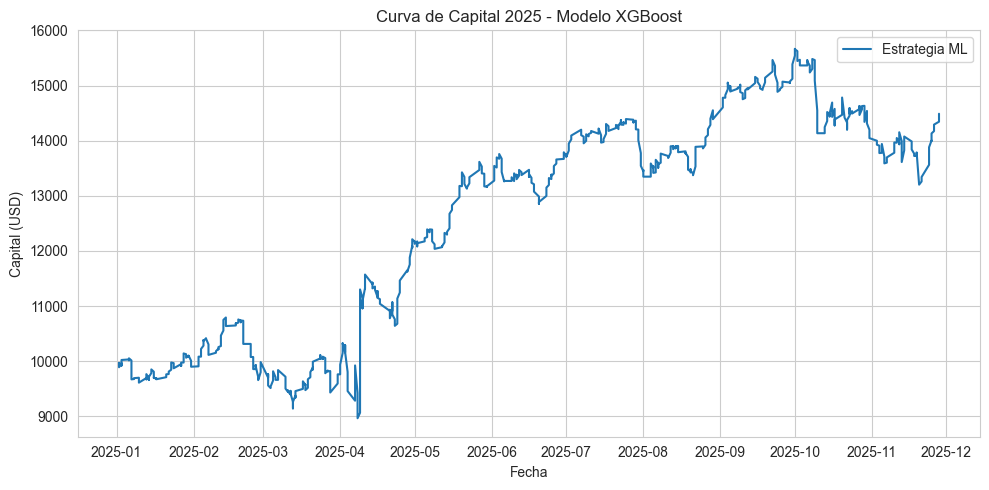

In [24]:
print("\n--- Iniciando Simulación de Inversión (2025) ---")

# Capital inicial
initial_capital = 10000
capital = initial_capital
capital_history = [initial_capital]
trades = 0

# Obtenemos los datos de 2025 con precios reales
simulation_df = df.loc[test_mask].copy()
simulation_df['prediction'] = y_pred_test # Usamos las predicciones del modelo ganador

# Regla de Trading:
# Pred = 1 (Up) -> Comprar en OPEN, Vender en CLOSE.
# Pred = 0 (Down) -> Mantener cash.

for date, row in simulation_df.iterrows():
    if row['prediction'] == 1:
        # Ejecutar Trade Intradía
        # Retorno = (Close - Open) / Open
        daily_return = (row['close'] - row['open']) / row['open']
        capital = capital * (1 + daily_return)
        trades += 1
    
    # Si predicción es 0, capital se mantiene igual 
    capital_history.append(capital)

final_value = capital
total_return_pct = ((final_value - initial_capital) / initial_capital) * 100
buy_hold_return = ((simulation_df.iloc[-1]['close'] - simulation_df.iloc[0]['open']) / simulation_df.iloc[0]['open']) * 100

print(f"\nResultados Simulación 2025 ({winner_name}):")
print(f"Capital Inicial: USD {initial_capital}")
print(f"Capital Final:   USD {final_value:.2f}")
print(f"Retorno Estrategia: {total_return_pct:.2f}%")
print(f"Retorno Buy & Hold: {buy_hold_return:.2f}% (Referencia)")
print(f"Total Operaciones: {trades}")

# Análisis de Errores vs Retorno
# Comparar métricas ML vs Métricas Financieras
print("\n--- Conclusión ---")
print(f"F1 Score en Test: {f1_score(y_test, y_pred_test):.4f}")
if total_return_pct > 0 and f1_score(y_test, y_pred_test) > 0.5:
    print("El modelo logró traducir capacidad predictiva en ganancias.")
elif total_return_pct < 0 and f1_score(y_test, y_pred_test) > 0.5:
    print("El modelo predice bien la dirección general, pero quizás falla en los días de grandes movimientos (magnitud vs dirección).")
else:
    print("El modelo no tuvo buen desempeño predictivo ni financiero.")

# Graficar curva de capital
plt.figure(figsize=(10,5))
plt.plot(simulation_df.index, capital_history[1:], label='Estrategia ML')
plt.title(f'Curva de Capital 2025 - Modelo {winner_name}')
plt.xlabel('Fecha')
plt.ylabel('Capital (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('equity_curve_2025.png')
print("Gráfico de curva de capital guardado como 'equity_curve_2025.png'")